In [1]:
import numpy as np
import time
import torch
import torch.fft as ft
import dynamic
from matplotlib import pyplot as plt
import torch.fft as ft
import gpytorch

from infer import FTMAGI
import dynamic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The imagry part from our datas are all zeros

In [2]:
# FN
seed = 637077689 # random seed
example = 'fn' # example
noise = [0.2,0.2] # noise level
no_train = 1281 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic
def FNode(theta, x):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)
theta = torch.tensor([1.,1.,5.]).double() # initial theta
fOde = dynamic.odeModule(FNode, theta)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FTMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer= model.map(max_epoch=magix_iteration,
                           learning_rate=1e-2,decay_learning_rate=False,
                           robust=False,robust_eps=0.10,
                           hyperparams_update=False,dynamic_standardization=False,
                           verbose=True,returnX=True,Truncated=True,k=None)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))
 
# trucation 1
# dense and truncation 2
# interpolation_orders

# FT on other components 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


1/1000 iteration: 187.857318
200/1000 iteration: 11.001706
400/1000 iteration: 9.541601
600/1000 iteration: 9.081056
800/1000 iteration: 8.889098
1000/1000 iteration: 8.801163
run time: 25.84 seconds


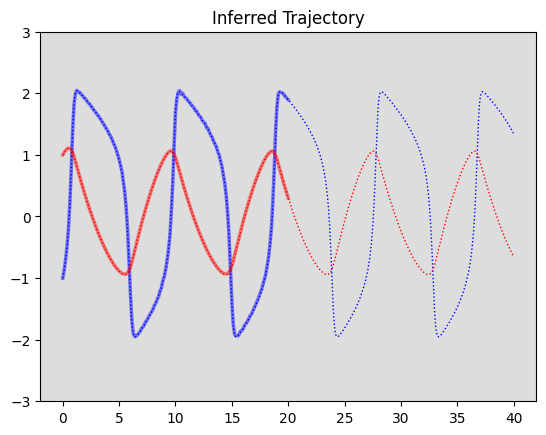

In [3]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    # ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

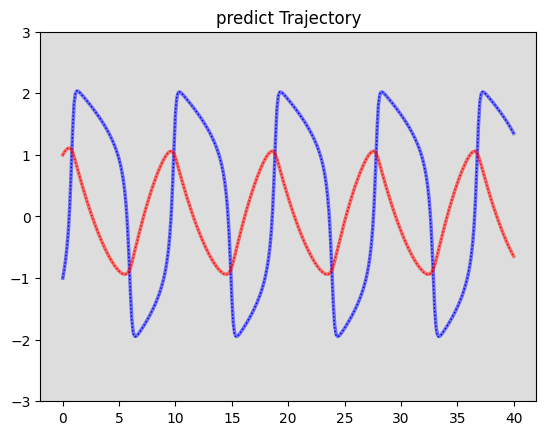

In [4]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    # ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('predict Trajectory')
plt.show()